# Tic tac toe com reinforcement learning

## Decisões a serem tomadas

* Quais os possíveis estados e como representá-los?
* Como representar uma ação? Sair de $s$ para $s'$

In [78]:
import ipywidgets as widgets
import numpy as np
import itertools
import re
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm.notebook import trange, tqdm

### Gerar todos os possíveis estados factíveis

In [23]:
class Environment:
    
    def __init__(self, agent_char='x'):
        self.agent_char = agent_char
        self.board_list_str = None
        self.board_list_arr = None
        self.board = None
        self.reset_env()
        
    def reset_env(self):
        self.board_list_arr = Environment.generate_valid_boards()
        self.board_list_str = Environment.convert_board_ndarray_to_str(self.board_list_arr)
        self.reset_board()
        
    def reset_board(self):
        self.board = ''.join([' ']*9)
        
    @classmethod
    def generate_valid_boards(self):
    
        # generate all possible boards
        board_buffer_arr = np.array(list(itertools.product('x o',repeat=9))).reshape(-1,3,3)

        # remove those whose difference between the number of 'x' and 'o' are greater than 2
        num_x = np.sum((board_buffer_arr == 'x').astype(int),axis=(1,2))
        num_o = np.sum((board_buffer_arr == 'o').astype(int),axis=(1,2))

        diff_x_o = np.abs(num_x - num_o)
        valid_board_idx = np.where(diff_x_o <=1)[0]
        board_buffer_arr = board_buffer_arr[valid_board_idx]


        #Diagonals

        # remove those with winning state from both sides ('x' and 'o')
        # and those with more than one winning condition
        xx = np.sum((np.sum((board_buffer_arr=='x').astype(int),axis=2) == 3).astype(int),axis=1)
        oo = np.sum((np.sum((board_buffer_arr=='o').astype(int),axis=2) == 3).astype(int),axis=1)    
        valid_board_idx = np.where((xx+oo < 2) == True)[0]
        board_buffer_arr = board_buffer_arr[valid_board_idx]

        xx = np.sum((np.sum((board_buffer_arr=='x').astype(int),axis=1) == 3).astype(int),axis=1)
        oo = np.sum((np.sum((board_buffer_arr=='o').astype(int),axis=1) == 3).astype(int),axis=1)    
        valid_board_idx = np.where((xx+oo < 2) == True)[0]
        board_buffer_arr = board_buffer_arr[valid_board_idx]

        return board_buffer_arr
    
    @classmethod
    def convert_board_ndarray_to_str(self, board):
        return np.apply_along_axis(lambda v: ''.join(v) , axis=1, arr=np.reshape(board,(-1,9))).tolist()

    @classmethod
    def convert_board_str_to_ndarray(self, board_list):
        if type(board_list) == str:
            return np.array([c for c in board_list]).reshape(3,3)
        elif type(board_list) == list:
            return np.array([[c for c in s] for s in board_list]).reshape(-1,3,3)

        return None

    @classmethod
    def draw_board(self, board):
        if type(board) == str:
            board = Environment.convert_board_str_to_ndarray(board)
        board_str = ''

        for i in board:
            for e, j in enumerate(i):
                board_str+=j
                if e < 2:
                    board_str+='|'
            board_str+='\n'
        return board_str

    @classmethod
    def create_board_value_function_memory(self, boards, agent_char='x'):
        value_fn_arr = np.ones(len(boards))*0.5

        opponent_char = 'x' if agent_char == 'o' else 'o'

        if type(boards) == list:
            board_str_list = boards
            board_arr_list = Environment.convert_board_str_to_ndarray(boards)
        elif type(boards) == np.ndarray:
            board_str_list = Environment.convert_board_ndarray_to_str(boards)
            board_arr_list = boards
        else:
            return None

        def _set_value_fn(_agent_char, value=0, axis=1, is_diag=False):
            if is_diag:
                winning_board_x_idx = np.where(np.sum((np.diagonal(board_arr_list,axis1=1,axis2=2) == _agent_char).astype(int),axis=1) == 3)[0]
                value_fn_arr[winning_board_x_idx] = value
                winning_board_x_idx = np.where(np.sum((np.diagonal(np.fliplr(board_arr_list),axis1=1,axis2=2) == _agent_char).astype(int),axis=1) == 3)[0]
                value_fn_arr[winning_board_x_idx] = value
            else:
                col_x = np.sum((board_arr_list == _agent_char).astype(int),axis=axis)
                winning_col_x = np.sum((col_x == 3).astype(int),axis=1)
                winning_board_x_idx = np.where(winning_col_x>=1)[0]
                value_fn_arr[winning_board_x_idx] = value

        # Set winning state for agent
        _set_value_fn(agent_char, 1, 1)
        _set_value_fn(agent_char, 1, 2)
        _set_value_fn(agent_char, 1, None, True)

        # Set losing state for agent
        _set_value_fn(opponent_char, 0, 1)
        _set_value_fn(opponent_char, 0, 2)
        _set_value_fn(opponent_char, 0, None, True)

        value_fn_list = value_fn_arr.tolist()

        value_fn_memory = {k:v for k,v in zip(board_str_list,value_fn_list)}

        return value_fn_memory

    @classmethod
    def is_terminal_state(self, board):
        board_ndarray = Environment.convert_board_str_to_ndarray(board)
        
        def _is_terminal_state(agent_char):        
            board_ndarray_bool = (board_ndarray == agent_char).astype(int)        
            terminal_v = np.any(np.sum(board_ndarray_bool,axis=0) == 3)
            terminal_h = np.any(np.sum(board_ndarray_bool,axis=1) == 3)
            terminal_d = np.any(np.sum(np.diag(board_ndarray_bool)) == 3)
            terminal_id = np.any(np.sum(np.diag(np.fliplr(board_ndarray_bool))) == 3)
            
            return terminal_v or terminal_h or terminal_d or terminal_id
        
        is_draw =  not ' ' in board
#         is_victory_x = 'x' if _is_terminal_state('x') and not is_draw else ''
#         is_victory_o = 'o' if _is_terminal_state('o') and not is_draw else ''
        
        
        return ( (_is_terminal_state('x') or _is_terminal_state('o') or is_draw) , is_draw)
#         return _is_terminal_state('x') or _is_terminal_state('o')
    
    @classmethod
    def get_possible_moves(self, board, agent_char):
        blank_positions = [m.start() for m in re.finditer(' ', board)]
        possible_states = []
        
        for s in blank_positions:
            possible_state = list(board)
            possible_state[s] = agent_char
            possible_state = ''.join(possible_state)
            possible_states.append(possible_state)
        
        return possible_states

## Agente

In [24]:
class Agent:
    
    def __init__(self, val_fn_memory, agent_char='x', alfa=0.5,epsilon=0.2):
        self.val_fn_memory = val_fn_memory
        self.agent_char = agent_char
        self.alfa = alfa
        self.epsilon = epsilon
    
    def next_move(self, env, is_training=True):
        
        possible_moves = Environment.get_possible_moves(env.board, self.agent_char)
        state_values = [self.val_fn_memory[m] for m in possible_moves] 
        best_action = np.argmax(state_values)
        best_value = state_values[best_action]
        
        if len(possible_moves) == 1:
            action = 0
        else:
            if is_training:
                if np.random.rand() < self.epsilon:
                    del possible_moves[best_action]
                    action = np.random.randint(0,len(possible_moves))
                else:
                    action = best_action
            else:
                    action = best_action
                
        return possible_moves[action], Environment.is_terminal_state(possible_moves[action])
    
    def update_val_fn(self, board, next_board):
        vst = self.val_fn_memory[board]
        vst_1 = self.val_fn_memory[next_board]
        vst = vst+self.alfa*(vst_1 - vst)
        self.val_fn_memory[board] = vst
    

### Treinar

Learning rate $\alpha$

In [4]:
alfa = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.05)
display(alfa)

FloatSlider(value=0.5, max=1.0, step=0.05)

Epsilon greedy $e$

In [5]:
epsilon = widgets.FloatSlider(value=0.2,min=0,max=1.0,step=0.05)
display(epsilon)

FloatSlider(value=0.2, max=1.0, step=0.05)

In [121]:
n_episodes = widgets.IntSlider(value=10,min=1,max=100000,step=1)
display(n_episodes)

IntSlider(value=10, max=100000, min=1)

In [122]:
def play_episode(agent_x, agent_o, environment, print_play=False):
    
    environment.reset_board()
    
    is_victory_x = False
    is_victory_o = False
    is_draw = False
    
    while True:
        next_state, (is_terminal, is_draw) =  agent_x.next_move(environment)
        
        agent_x.update_val_fn(environment.board,next_state)
        environment.board = next_state
        
        if print_play:
            print(Environment.draw_board(environment.board))
        
        if is_terminal:
            if not is_draw:
                is_victory_x = True
            else:
                is_draw = True
            break

        
        next_state, (is_terminal, is_draw) =  agent_o.next_move(environment)
        
        agent_o.update_val_fn(environment.board,next_state)
        environment.board = next_state
        
        if print_play:
            print(Environment.draw_board(environment.board))
        
        if is_terminal:
            if not is_draw:
                is_victory_o = True
            else:
                is_draw = True
            break    
            
    
    return agent_x, agent_o, is_victory_x, is_victory_o, is_draw
    
    

In [129]:
environment = Environment()
agent_x = Agent(Environment.create_board_value_function_memory(environment.board_list_arr, 'x'), 'x')
agent_o = Agent(Environment.create_board_value_function_memory(environment.board_list_arr, 'o'), 'o')

victory_x_count = 0
victory_o_count = 0
draw_count = 0

victory_x_list = []
victory_o_list = []
draw_list = []


for episode in tqdm(range(n_episodes.value)):
    
    agent_x, agent_o, is_victory_x, is_victory_o, is_draw = play_episode(agent_x, agent_o, environment, False)
    
    if is_victory_x:
        victory_x_count+=1
    if is_victory_o:
        victory_o_count+=1
    if is_draw:
        draw_count+=1
        
    victory_x_list.append(victory_x_count)
    victory_o_list.append(victory_o_count)
    draw_list.append(draw_count)
    

  0%|          | 0/10003 [00:00<?, ?it/s]

<AxesSubplot:>

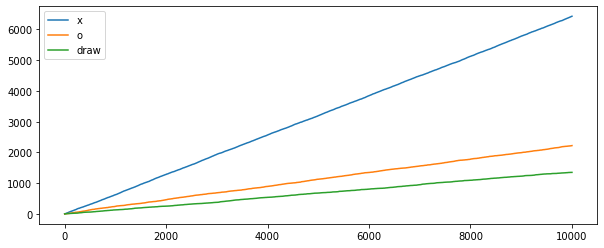

In [130]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(y=victory_x_list,x=range(n_episodes.value),label='x',ax=ax)
sns.lineplot(y=victory_o_list,x=range(n_episodes.value),label='o',ax=ax)
sns.lineplot(y=draw_list,x=range(n_episodes.value),label='draw',ax=ax)

In [127]:
_ = play_episode(agent_x, agent_o, environment, True)

x| | 
 | | 
 | | 

x| | 
 | | 
 | |o

x|x| 
 | | 
 | |o

x|x|o
 | | 
 | |o

x|x|o
x| | 
 | |o

x|x|o
x| |o
 | |o



In [131]:
agent_x.val_fn_memory

{'xxxx o oo': 1.0,
 'xxxx oo o': 1.0,
 'xxxx ooo ': 1.0,
 'xxxxo  oo': 1.0,
 'xxxxo o o': 1.0,
 'xxxxo oo ': 1.0,
 'xxxxooxoo': 1.0,
 'xxxxoo  o': 1.0,
 'xxxxoo o ': 1.0,
 'xxxxoo oo': 1.0,
 'xxxxoooxo': 1.0,
 'xxxxooo  ': 1.0,
 'xxxxooo o': 1.0,
 'xxxxoooox': 1.0,
 'xxxxoooo ': 1.0,
 'xxx xo oo': 1.0,
 'xxx xoo o': 1.0,
 'xxx xooo ': 1.0,
 'xxx    oo': 1.0,
 'xxx   o o': 1.0,
 'xxx   oo ': 1.0,
 'xxx  oxoo': 1.0,
 'xxx  o  o': 1.0,
 'xxx  o o ': 1.0,
 'xxx  o oo': 1.0,
 'xxx  ooxo': 1.0,
 'xxx  oo  ': 1.0,
 'xxx  oo o': 1.0,
 'xxx  ooox': 1.0,
 'xxx  ooo ': 1.0,
 'xxx ox oo': 1.0,
 'xxx oxo o': 1.0,
 'xxx oxoo ': 1.0,
 'xxx o xoo': 1.0,
 'xxx o   o': 1.0,
 'xxx o  o ': 1.0,
 'xxx o  oo': 1.0,
 'xxx o oxo': 1.0,
 'xxx o o  ': 1.0,
 'xxx o o o': 1.0,
 'xxx o oox': 1.0,
 'xxx o oo ': 1.0,
 'xxx oox o': 1.0,
 'xxx ooxo ': 1.0,
 'xxx ooxoo': 1.0,
 'xxx oo xo': 1.0,
 'xxx oo   ': 1.0,
 'xxx oo  o': 1.0,
 'xxx oo ox': 1.0,
 'xxx oo o ': 1.0,
 'xxx oo oo': 1.0,
 'xxx ooox ': 1.0,
 'xxx oooxo'